# pycbf - Basic example

This notebook roughly simulates channel data and beamforms it

In [1]:
import numpy as np
from pycbf import PWBeamformer
import matplotlib.pyplot as plt
import scipy.signal as sig
import ctypes as ct

## Generating channel data

In [2]:
# channel data parameters
fc = 5E6        # centerfrequency of plane wave excitation [Hz]
fs = 36 * fc    # sampling frequency [Hz]
c = 1540        # speed of sound [m/s]
lam = c/fc      # wavelength [m]

nele = 32       # number of elements in probe
dele = lam      # probe spacing [m]

# location of point scatterer
point = np.array([[0, 0, nele*dele/2]])

# locations of elements
xele = dele*(np.arange(nele) - (nele-1)/2)
yele = 0
zele = 0
Xele, Yele, Zele = np.meshgrid(xele, yele, zele, indexing='ij')
eles = np.array([Xele.flatten(), Yele.flatten(), Zele.flatten()]).T

# reconstruction grid
xgrid = dele*(np.arange(0, nele, 1/8) - (nele-1)/2)
ygrid = 0
zgrid = np.arange(1*lam, nele*dele, lam/4)
Xgrid, Ygrid, Zgrid = np.meshgrid(xgrid, ygrid, zgrid, indexing='ij')
grid = np.array([Xgrid.flatten(), Ygrid.flatten(), Zgrid.flatten()]).T

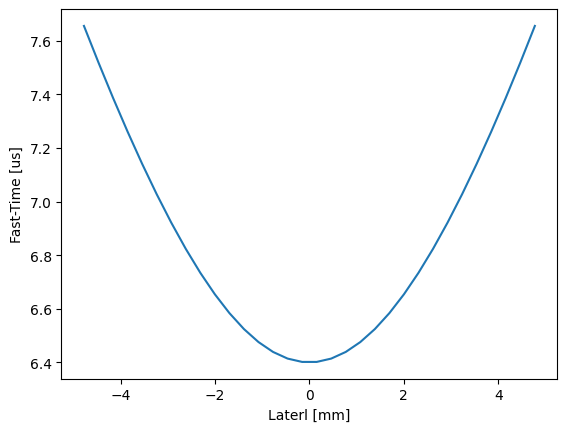

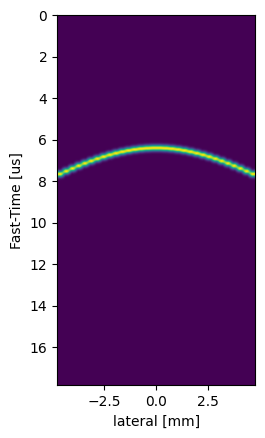

In [3]:
# time delays along each channel until return pulse
tau = (point[0, 2] + np.linalg.norm(eles-point, axis=1).reshape((1,-1)))/c

# generate all (realtive) time points for each pulse
tmax = 2*np.sqrt((dele * (nele-1))**2 + (nele*dele)**2)/c
t = np.arange(0, tmax, 1/fs).reshape((-1,1))
T = t - tau

rf = sig.gausspulse(t=T, fc=fc, bw=0.75)

# plot delay tabs
plt.figure()
plt.plot(1E3*xele, 1E6*tau.flatten())
plt.xlabel("Laterl [mm]")
plt.ylabel("Fast-Time [us]")
plt.show()

env = np.abs(sig.hilbert(rf, axis=0))
plt.figure()
plt.imshow(env, extent=[1E3*xele[0], 1E3*xele[-1], 1E6*t.flatten()[-1], 0])
plt.xlabel("lateral [mm]")
plt.ylabel("Fast-Time [us]")
plt.show()

In [4]:
# initialize beamformer
funcparams = {}
funcparams['c'] = c
funcparams['fnum'] = 1
funcparams['points'] = grid
funcparams['trefs'] = np.zeros(nele)
funcparams['refs'] = eles
funcparams['alphas'] = np.zeros(nele)
funcparams['nsamp'] = rf.shape[0]
funcparams['fs'] = fs
funcparams['tstart'] = 0
funcparams['parallel'] = True

bmfrm = PWBeamformer(**funcparams)

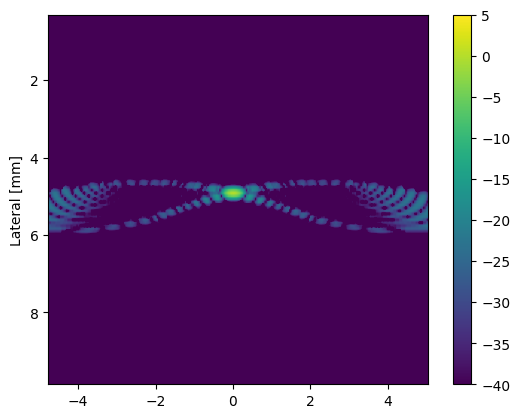

In [5]:
# convert data to contiguous, c-order, c_type pointer
rf_pntr = np.ascontiguousarray(rf.T, dtype=ct.c_float).ctypes.data_as(ct.POINTER(ct.c_float))

# beamform and reshape data
formed = bmfrm(rf_pntr).reshape((len(xgrid), -1)).T

# calcualte envelope and compress
env = np.abs(formed)
logged = 20*np.log10(env/np.max(env)+1E-100)

plt.figure()
plt.imshow(logged, vmin=-40, vmax=5,
    extent = 1E3*np.array([np.min(xgrid), np.max(xgrid), np.max(zgrid), np.min(zgrid)])
)
plt.colorbar()
plt.ylabel("Axial [mm]")
plt.ylabel("Lateral [mm]")
plt.show()